In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import xarray as xr
import pandas as pd
import os
from glob import glob
from paulinggrl2022.model import Model
from paulinggrl2022.cesm_functions import fixmonth, globalmean
from scipy.stats import linregress

mpl.rcParams["figure.figsize"] = 6, 4
mpl.rcParams["font.size"] = 10

In [2]:
from dask_jobqueue import PBSCluster

cluster = PBSCluster(project='UWAS0052',
                     queue='casper',
                     cores=18,
                     processes=9,
                     memory='200G',
                     walltime="03:00:00",
                     resource_spec='select=1:ncpus=18:mem=200GB')
cluster.scale(18)

from dask.distributed import Client

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/apauling/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/apauling/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.51:39192,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/apauling/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
models = [
    "ACCESS-ESM1-5",
    "CanESM5",
    "CESM2",
    "CNRM-CM6-1",
    "EC-Earth3",
    "GISS-E2-1-G",
    "GISS-E2-1-H",
    "INM-CM5-0",
    "IPSL-CM6A-LR",
    "MIROC-ES2L",
    "MIROC6",
    "MPI-ESM1-2-HR",
    "MPI-ESM1-2-LR",
    "MRI-ESM2-0",
    "NorCPM1",
    "UKESM1-0-LL"
]

experiments = ["historical", "abrupt-4xCO2"]

### Instructions for getting CMIP6 data needed for this calculation

### <font color="red">WARNING: This will download a LOT of data. Best to do this on an HPC environment</font>

 - Download the git repository here: https://github.com/tloureiro/cmip6_downloader
 - Use the `cmip6_downloader.py` tool to get both the historical and abrupt-4xCO2 data for all the models listed in the cell above
 - Modify the script `process_data.py` in `paulinggrl2022/paulinggrl2022` to point to where you downloaded the data and run it to generate concatenated files
 - Create a symbolic link in the `paulinggrl2022/data` directory to point to where your data is like so:
 ```
 ln -s <path_to_your_data> cmip6data
 ```
 - Run the code from this point forwards
 

In [4]:
ddict = {}

for name in models:
    ddict[name] = {}
    print(name)
    
    for exp in experiments:
        model = Model(name, exp, "tas")
        model.process_data()
        model.load_ensemble()
        if exp == "historical":
            da = model.dataset["tas"].sel(time=slice("1986-01", "1999-12"))
        else:
            da = model.dataset["tas"].isel(time=slice(None, 1800))

        ddict[name][exp] = da.groupby("time.year").mean("time")

ACCESS-ESM1-5
CanESM5
CESM2
CNRM-CM6-1
EC-Earth3
GISS-E2-1-G
GISS-E2-1-H
INM-CM5-0
IPSL-CM6A-LR
MIROC-ES2L
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NorCPM1
UKESM1-0-LL


### Fix weird latitude issue with EC-Earth data

In [5]:
droot = "../data/cmip6data"
ddir = "v_tas_f_mon_e_historical_s_EC-Earth3/processed"
dfiles = sorted(glob(os.path.join(droot, ddir, "*.nc")))

ds = xr.open_dataset(dfiles[0])
lat = ds["lat"].data

for exp in experiments:
    ddict["EC-Earth3"][exp] = ddict["EC-Earth3"][exp].assign_coords({"lat": ("lat", lat)})

In [2]:
def compute_warm_pool(da):
    # Computes the warm pool region temperature as defined in Gunther et al. (2022)
    tmp = da.sel(lat=slice(-30, 30), lon=slice(50, 200))
    return tmp.weighted(np.cos(np.deg2rad(tmp.lat))).mean(("lat", "lon"))

In [7]:
gmst = {}
warmpool = {}

for name in models:
    print(name)
    gmst[name] = {}
    warmpool[name] = {}
    for exp in experiments:
        gmst[name][exp] = globalmean(ddict[name][exp]).mean("ensmem").compute()
        warmpool[name][exp] = compute_warm_pool(ddict[name][exp]).mean("ensmem").compute()

ACCESS-ESM1-5
CanESM5
CESM2
CNRM-CM6-1
EC-Earth3
GISS-E2-1-G
GISS-E2-1-H
INM-CM5-0
IPSL-CM6A-LR
MIROC-ES2L
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NorCPM1
UKESM1-0-LL


### Compute the Warm Pool Index as defined in G&uuml;nther et al. (2022)

In [8]:
wpi = {}
for name in models:
    wpi[name] = {}
    for exp in experiments:
        if exp == "historical":
            g = gmst[name][exp].sel(year=slice(1991, 1993))
            w = warmpool[name][exp].sel(year=slice(1991, 1993))
        else:
            g = gmst[name][exp].isel(year=slice(0, 150))
            w = warmpool[name][exp].isel(year=slice(0, 150))

        slope, intcpt, r, p, stderr = linregress(g.data, w.data)
        print(f"{name}: {slope:5.3f}")

        wpi[name][exp] = slope

ACCESS-ESM1-5: 1.136
ACCESS-ESM1-5: 0.742
CanESM5: 1.191
CanESM5: 0.824
CESM2: 0.857
CESM2: 0.889
CNRM-CM6-1: 0.749
CNRM-CM6-1: 0.791
EC-Earth3: 1.082
EC-Earth3: 0.753
GISS-E2-1-G: 1.114
GISS-E2-1-G: 1.063
GISS-E2-1-H: 1.114
GISS-E2-1-H: 0.836
INM-CM5-0: 0.874
INM-CM5-0: 0.716
IPSL-CM6A-LR: 0.923
IPSL-CM6A-LR: 0.825
MIROC-ES2L: 1.043
MIROC-ES2L: 0.893
MIROC6: 0.834
MIROC6: 0.923
MPI-ESM1-2-HR: 1.336
MPI-ESM1-2-HR: 0.846
MPI-ESM1-2-LR: 1.124
MPI-ESM1-2-LR: 0.885
MRI-ESM2-0: 1.028
MRI-ESM2-0: 0.857
NorCPM1: 1.189
NorCPM1: 0.708
UKESM1-0-LL: 1.114
UKESM1-0-LL: 0.779


In [9]:
import json

f = open('../data/ecsdata/cmip56_forcing_feedback_ecs.json','r')
data = json.load(f)

ecs_dict = {}

for name in models:
    ens = list(data["CMIP6"][name].keys())[0]
    test = data["CMIP6"][name][ens]["ECS"]
    print(f"{name} = {test}")
    ecs_dict[name] = test
    
ecs_dict["CESM2-LENS"] = ecs_dict["CESM2"]

ACCESS-ESM1-5 = 3.8839034758064876
CanESM5 = 5.638903077035479
CESM2 = 5.147915202979365
CNRM-CM6-1 = 4.9036506204610255
EC-Earth3 = 4.2600669989023405
GISS-E2-1-G = 2.635084837796116
GISS-E2-1-H = 3.1173410786926183
INM-CM5-0 = 1.9158220047671057
IPSL-CM6A-LR = 4.699160878253559
MIROC-ES2L = 2.6605264351565174
MIROC6 = 2.601790969650521
MPI-ESM1-2-HR = 2.9797516932086876
MPI-ESM1-2-LR = 3.0254401947450527
MRI-ESM2-0 = 3.1327957128560495
NorCPM1 = 3.031725720887037
UKESM1-0-LL = 5.359162439690016


In [10]:
delta_wpi = np.array([wpi[name]["historical"] - wpi[name]["abrupt-4xCO2"] for name in models])
ecs = np.array([ecs_dict[name] for name in models])

slope, intcpt, r, p, stderr = linregress(ecs, delta_wpi)
print(f"Slope= {slope:5.3f}")
print(f"r = {r:5.3f}")
print(f"p = {p:5.3f}")

Slope= 0.004
r = 0.025
p = 0.926


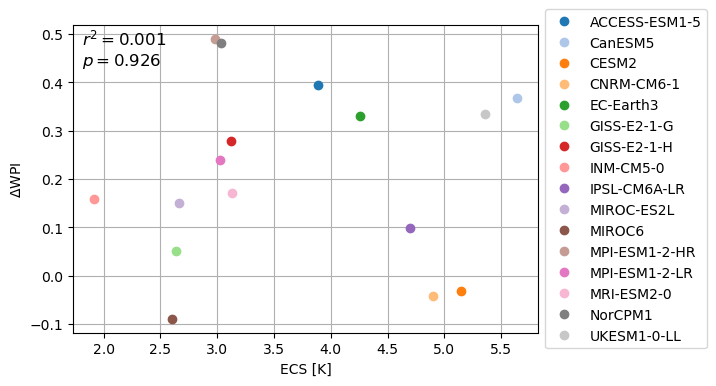

In [11]:
colors = pl.cm.tab20.colors

fig = plt.figure(1)
for n, name in enumerate(models):
    delta_wpi = wpi[name]["historical"] - wpi[name]["abrupt-4xCO2"]
    plt.plot(ecs_dict[name], delta_wpi, "o", label=name, color=colors[n])
    
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.grid()
plt.xlabel("ECS [K]")
plt.ylabel("$\Delta$WPI")

plt.annotate(
    f"$r^2=${r**2:5.3f}\n$p=${p:5.3f}",
    xy=(0.02, 0.87),
    xycoords="axes fraction",
    fontsize=12
)

fig.savefig("../figures/deltawpi_150yr_vs_ecs.png",
            bbox_inches="tight", dpi=300)